In [102]:
import pandas as pd 
import json
import numpy as np

In [103]:
#Lecture des données
tunisian_stock_market = 'Tunisian-Stock-Market.json'
with open(tunisian_stock_market, 'r') as json_file:
    
    json_data = json.load(json_file)
TunisianStockMarket = pd.DataFrame(json_data)

In [104]:
#Choix d'une seule action(BNA dans notre cas)
TunisianStockMarket['Date'] = pd.to_datetime(TunisianStockMarket['Date'])
bna_data = TunisianStockMarket[TunisianStockMarket['Stock_name'] == 'BNA']

In [105]:
#Filtrage des colonnes non utile
columnsToExclude = ['Code_isin','Stock_name']
TunisianStockMarketFiltred = bna_data.drop(columns=columnsToExclude)
TunisianStockMarketFiltred = TunisianStockMarketFiltred[TunisianStockMarketFiltred['Date'].dt.year.isin([2020,2021])]
TunisianStockMarketFiltred = TunisianStockMarketFiltred.sort_values(by='Date')
print(TunisianStockMarketFiltred)

            Date  Adj_Close  Adj_low  Adj_High         Volume
36543 2020-01-02     11.119   10.932    11.119  121707.617188
36461 2020-01-03     11.119   10.932    11.119  148407.296875
36379 2020-01-06     11.110   10.699    11.119   13605.860352
36297 2020-01-07     11.016   10.839    11.026   23297.710938
36215 2020-01-08     10.932   10.792    11.119   24156.599609
...          ...        ...      ...       ...            ...
378   2021-10-29      7.340    7.300     7.340    6610.660156
299   2021-11-01      7.320    7.200     7.340    5781.819824
220   2021-11-02      7.310    7.200     7.320   24964.289062
141   2021-11-03      7.320    7.100     7.320   34433.000000
62    2021-11-04      7.320    7.220     7.320    6137.930176

[457 rows x 5 columns]


In [106]:
#Function to make date format to datetime
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year , month , day = int(split[0]) , int(split[1]) , int(split[2])
    return datetime.datetime(year=year , month=month , day=day)

In [107]:
#TunisianStockMarketFiltred['Date'] = TunisianStockMarketFiltred['Date'].apply(str_to_datetime)
#TunisianStockMarketFiltred['Date']

In [108]:
TunisianStockMarketFiltred.index = TunisianStockMarketFiltred.pop('Date')
TunisianStockMarketFiltred

,Adj_Close,Adj_low,Adj_High,Volume
Date,,,,
2020-01-02,11.119,10.932,11.119,121707.617188
2020-01-03,11.119,10.932,11.119,148407.296875
2020-01-06,11.110,10.699,11.119,13605.860352
2020-01-07,11.016,10.839,11.026,23297.710938
2020-01-08,10.932,10.792,11.119,24156.599609
...,...,...,...,...
2021-10-29,7.340,7.300,7.340,6610.660156
2021-11-01,7.320,7.200,7.340,5781.819824
2021-11-02,7.310,7.200,7.320,24964.289062


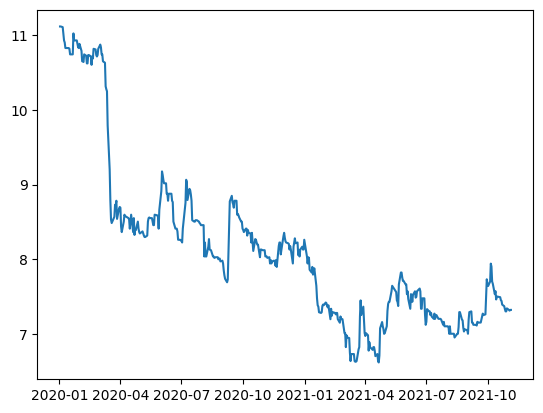

In [109]:
import matplotlib.pyplot as plt 

plt.plot(TunisianStockMarketFiltred.index , TunisianStockMarketFiltred['Adj_Close'])

In [110]:
#Create windowed data every 3 days
def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Adj_Close'].shift(i)
    windowed_data['Target'] = data['Adj_Close']
    return windowed_data.dropna()


windowed_data = window_data(TunisianStockMarketFiltred, n = 3)
windowed_data.sort_index(inplace=True, ascending=True)
windowed_data

,Target-3,Target-2,Target-1,Target
Date,,,,
2020-01-07,11.119,11.119,11.110,11.016
2020-01-08,11.119,11.110,11.016,10.932
2020-01-09,11.110,11.016,10.932,10.904
2020-01-10,11.016,10.932,10.904,10.830
2020-01-13,10.932,10.904,10.830,10.830
...,...,...,...,...
2021-10-29,7.330,7.300,7.300,7.340
2021-11-01,7.300,7.300,7.340,7.320
2021-11-02,7.300,7.340,7.320,7.310


In [111]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = windowed_dataframe.index.values

  middle_matrix = df_as_np[:, 0:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_data)

dates.shape, X.shape, y.shape


((454,), (454, 3, 1), (454,))

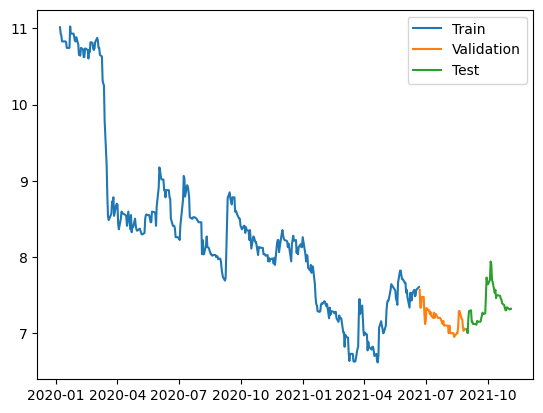

In [112]:
q_60 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_60], X[:q_60], y[:q_60]
dates_val, X_val, y_val = dates[q_60:q_90], X[q_60:q_90], y[q_60:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [113]:
from tensorflow.keras.models import Sequential #Sequential model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 
import distutils



model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64),
                    layers.Dense(32 , activation='relu'),
                    layers.Dense(32 , activation='relu'),
                    layers.Dense(1)])

model.compile(loss='MSE' ,
               optimizer=Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error'])

model.fit(X_train, y_train , validation_data = (X_val , y_val) , epochs=100)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 73.8033 - mean_absolute_error: 8.5283 - val_loss: 49.3529 - val_mean_absolute_error: 7.0513
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66.5087 - mean_absolute_error: 8.0835 - val_loss: 44.0651 - val_mean_absolute_error: 6.6633
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.3963 - mean_absolute_error: 7.5800 - val_loss: 34.6211 - val_mean_absolute_error: 5.9075
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45.6156 - mean_absolute_error: 6.6719 - val_loss: 18.2956 - val_mean_absolute_error: 4.2983
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.7314 - mean_absolute_error: 4.6304 - val_loss: 1.2922 - val_mean_absolute_error: 1.1504
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3169 - mean_absolute_error: 1.4499 - val_loss: 3.8550 - val_mean_absolute_error: 1.9422
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9722 - mean_absolute_error: 1.3132 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


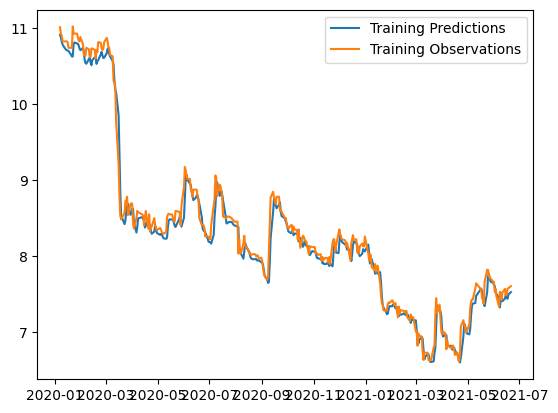

In [114]:
train_prediction = model.predict(X_train).flatten()

plt.plot(dates_train , train_prediction)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions' , 'Training Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


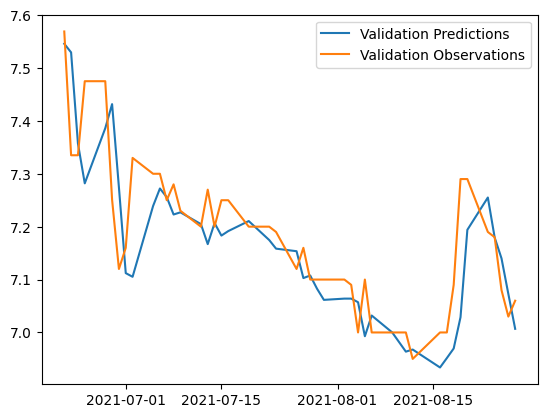

In [115]:
val_prediction = model.predict(X_val).flatten()

plt.plot(dates_val , val_prediction)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions' , 'Validation Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


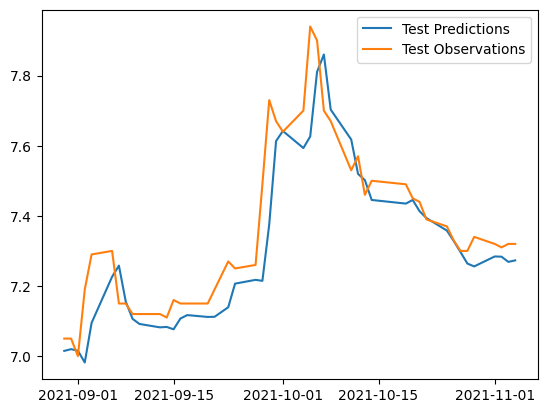

In [116]:
test_prediction = model.predict(X_test).flatten()

plt.plot(dates_test , test_prediction)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions' , 'Test Observations'])

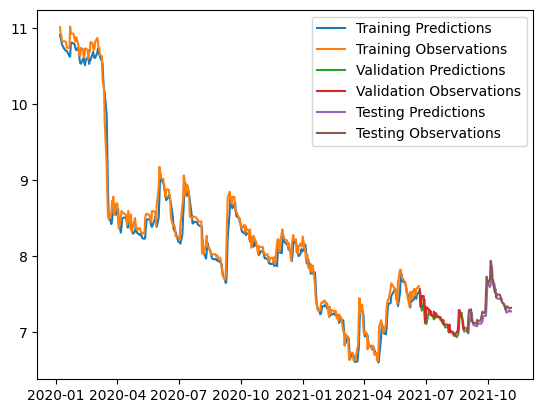

In [117]:
plt.plot(dates_train, train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_prediction)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [118]:
from copy import deepcopy

recursive_predictions = []
recursive_dates=np.concatenate([dates_val, dates_test])
last_window = deepcopy(X_train[-1])

for target_date in recursive_dates:
    next_prediction=model.predict(np.array([last_window[-3:]])).flatten()
    recursive_predictions.append(next_prediction)
    last_window=np.concatenate((last_window,[next_prediction]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

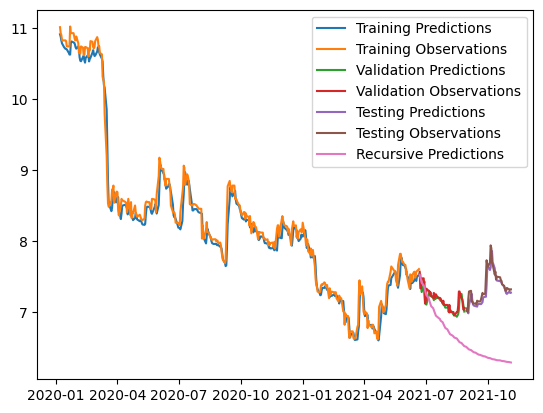

In [119]:
plt.plot(dates_train, train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_prediction)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])